In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn

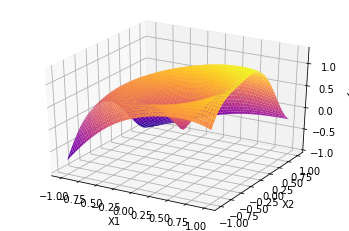

In [3]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1 + (X1+X2)/3

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [4]:
dynet = dynn.Dynamic_Network(2, 1, num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.MSELoss()

In [5]:
### hyperparameters
num_add_neuron = 5
num_decay_steps = 1000
threshold_max = 0.1
threshold_min = 0.001
learning_rate = 0.01

## Train Network dynamically

In [60]:
dynet.add_neurons(num_add_neuron)

In [61]:
dynet.print_network()

2
└────┐
     ├────┐
     │    6
     ├────┘
     9
     ├────┐
     │    4
     ├────┘
┌────┘
│
1


In [73]:
optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)

### Training Step

In [74]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(1000):

    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.    

    yout = dynet(xx)
    loss = criterion(yout, yy) #+ dynet.tree.decay_rate_std*dynet.tree.std_loss
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()

        ax.scatter(X1, X2, Y, marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

plt.close()

Epoch: 0, Loss:0.0015269243158400059


Epoch: 100, Loss:0.0010114583419635892


Epoch: 200, Loss:0.0009620696073397994


Epoch: 300, Loss:0.0009586821543052793


Epoch: 400, Loss:0.0009582836646586657


Epoch: 500, Loss:0.0009483332978561521


Epoch: 600, Loss:0.0009336349321529269


Epoch: 700, Loss:0.000929275993257761


Epoch: 800, Loss:0.0009172667050734162


Epoch: 900, Loss:0.0008990609785541892




In [64]:
# for i in dynet.tree.freeze_connection_shortcut:
#     if i.to_freeze is not None:
#         print('__')
#     print(i.to_freeze)

In [65]:
dynet.print_network_debug()

H:0[2,1]σ[t:0.9999999999999862, s:1.0
|     R:1[9|9]
|     |     H:2[2,9]σ[t:0.8566702029301551, s:0.6229746341705322
|     |     |     S:3[2,9]
|     |     |     R:3[6|6]
|     |     |     |     H:4[2,6]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[2,6]
|     |     |     |     H:4[6,9]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[6,9]
|     |     H:2[9,1]σ[t:0.6617998653102668, s:0.4775015711784363
|     |     |     S:3[9,1]
|     |     |     R:3[4|4]
|     |     |     |     H:4[9,4]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[9,4]
|     |     |     |     H:4[4,1]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[4,1]


## Compute Significance

In [66]:
dynet.start_computing_significance()

for epoch in range(1):
    yout = dynet(xx)
    yout.backward(gradient=torch.ones_like(yout))
    optimizer.zero_grad()

dynet.finish_computing_significance()

#### start removing less significant neurons

In [67]:
dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)

(tensor(0.0687),
 tensor([0.4186, 0.2917, 0.5317, 0.6250, 0.7061, 0.0687, 0.3457, 0.2463, 0.4092,
         0.2156, 0.8815, 0.5093, 0.2294, 0.1866, 0.1669, 1.3882, 0.7880, 0.8665,
         0.3774]))

In [68]:
dynet.decay_neuron_start(decay_steps=1000)

1

#### compute del_neuron statstics after removing neurons

In [69]:
dynet.compute_del_neurons()

## Maintain Structure of Network

In [70]:
dynet.maintain_network()

In [71]:
dynet.print_network()

2
└────┐
     ├────┐
     │    6
     ├────┘
     9
     ├────┐
     │    4
     ├────┘
┌────┘
│
1


In [72]:
len(dynet.tree.DYNAMIC_LIST)

3

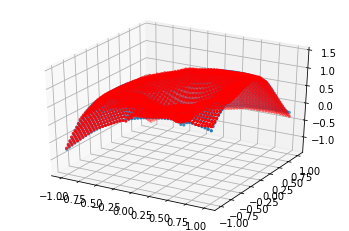

In [75]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

yout = dynet(xx)
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')